In [1]:
import pandas as pd
import json
from scipy.stats import zscore
from scipy.stats import ttest_ind
import os
from numpy import std, mean, sqrt

In [2]:
def jaccard(a,b):
    return len(a.intersection(b)) / len(a.union(b))

In [3]:
def short2long(trans):
    ui, uj = tuple(trans.split(":"))
    ui = int("20" + ui)
    uj = int("20" + uj)
    return ui, uj

In [4]:
def get_sign_change(df, th=4.781):
    d = dict()
    for word in df.index:
        for col in df.columns:
            if df.loc[word][col] > th:
                if word in d:
                    d[word].append(short2long(col))
                else:
                    d[word] = [short2long(col)]
    return d

In [5]:
def get_years(df):
    years = [short2long(col) for col in df.columns]
    i, j = zip(*years)
    years = set(i + j)
    years = sorted(list(years))
    return years

In [6]:
def get_nbh(df, word, year):
    nbh = df[(df["Word"] == word) & (df["Year"] == year)]["Neighbor"].tolist()
    return set(nbh)

In [7]:
def build_big(df_cng, df_nbh, th=4.781):
    """ Builds term by year matrix with neighbors in cells
    """
    
    
    big = []
    years = get_years(df_cng)
    print("YEARS:", years)
    for word in df_cng.index:
        line = {year: "" for year in years}
        line["Word"] = word
        
        for col in sorted(df_cng.columns):
            x = df_cng.loc[word][col]
            if pd.isna(x):
                continue
            ui, uj = short2long(col)
            
            nbh_i = get_nbh(df_nbh, word, ui)
            nbh_j = get_nbh(df_nbh, word, uj)

            cell_i = ["XXXXXXX"] if x > th else [""]
            cell_j = ["XXXXXXX"] if x > th else [""]
            cell_i.extend(list(nbh_i))
            cell_j.extend(list(nbh_j))
            
            if line[ui] == "":
                line[ui] = "\n".join(cell_i)
            if line[uj] == "":
                line[uj] = "\n".join(cell_j)
                
        big.append(line)
        
    big = pd.DataFrame(big)
    column_to_move = big.pop("Word")
    big.insert(0, "Word", column_to_move)    
    
    return big

In [7]:
def build_json(df_cng, df_nbh, th=4.781):
    """ Builds dictionary (json)
            {
                "sig": {
                    "year:year": {
                        "to": [nbh1, ...],
                        "from": [nbh1, ...]
                        },
                    "year:year": {...}
                    },
                "non-sig": {...}
            }
    """
   
    d = {"sig": {}, "non-sig": {}}
    
    years = get_years(df_cng)
    print("YEARS:", years)
    
    for word in df_cng.index:
        line = {year: "" for year in years}
        line["Word"] = word
        
        for col in sorted(df_cng.columns):
            x = df_cng.loc[word][col]
            if pd.isna(x):
                continue
            ui, uj = short2long(col)
            
            nbh_i = get_nbh(df_nbh, word, ui)
            nbh_j = get_nbh(df_nbh, word, uj)
            
            if x > th:
                d["sig"][f"{ui}:{uj}"] = {
                    "from": nbh_i,
                    "to": nbh_j
                }
            else:
                d["non-sig"][f"{ui}:{uj}"] = {
                    "from": nbh_i,
                    "to": nbh_j
                }
   
    return d

In [8]:
def score_comp(df_cng, df_nbh):
    trm = []
    cos = []
    jcd = []
    for word in df_cng.index:

        for col in df_cng.columns:
            x = df_cng.loc[word][col]
            if pd.isna(x):
                trm.append(word)
                cos.append(None)
                jcd.append(None)
                continue
                
            ui, uj = short2long(col)

            nbh_i = get_nbh(df_nbh, word, ui)
            nbh_j = get_nbh(df_nbh, word, uj)
            
            trm.append(word)
            cos.append(x)
            jcd.append(jaccard(nbh_i, nbh_j))
    
    df = pd.DataFrame({"Word": trm, "Cosine": cos, "Jaccard": jcd})
    df = df.dropna(axis=0)
    df["zCosine"] = zscore(df["Cosine"])
    df["zJaccard"] = zscore(df["Jaccard"])
    df["SigChange"] = df["Cosine"] > 4.781
    
    return df

In [9]:
#https://stackoverflow.com/questions/21532471/how-to-calculate-cohens-d-in-python
#correct if the population S.D. is expected to be equal for the two groups.
def cohen_d(x,y):
    nx = len(x)
    ny = len(y)
    dof = nx + ny - 2
    return (mean(x) - mean(y)) / sqrt(((nx-1)*std(x, ddof=1) ** 2 + (ny-1)*std(y, ddof=1) ** 2) / dof)


## Files

In [10]:
os.listdir("../../dw_results/change_tables/")

['sgns-yearly-change.csv',
 'sts-tbn-change.csv',
 'sgns-tbn-change.csv',
 'sts-yearly-change.csv']

In [11]:
os.listdir("../../dw_results/neighbors/")

['nbh-yearly-min100.json',
 'nbh-tbn-min100.csv',
 'nbh-tbn-min100.json',
 'nbh-yearly.json',
 'nbh-yearly.csv',
 'nbh-yearly-min100.csv',
 'nbh-tbn.csv',
 'nbh_yrl_BIG.csv',
 'nbh_tbn_BIG100.csv',
 'nbh_yrl_BIG100.csv',
 'neighbors.csv',
 'nbh_tbn_BIG.csv',
 'neighbors.json',
 'nbh-tbn.json',
 'nbh_tbn_BIG100.ods']

### Change

In [12]:
sgns_cng_yrl = pd.read_csv("../../dw_results/change_tables/sgns-yearly-change.csv", sep = ";", index_col=0)

In [13]:
sgns_cng_tbn = pd.read_csv("../../dw_results/change_tables/sgns-tbn-change.csv", sep = ";", index_col=0)

### Neighbors

In [14]:
nbh_yrl = pd.read_csv("../../dw_results/neighbors/nbh-yearly.csv", sep = "\t", index_col=0)   

In [15]:
nbh_tbn = pd.read_csv("../../dw_results/neighbors/nbh-tbn.csv", sep = "\t", index_col=0)   

In [16]:
nbh_yrl100 = pd.read_csv("../../dw_results/neighbors/nbh-yearly-min100.csv", sep = "\t", index_col=0)   

In [17]:
nbh_tbn100 = pd.read_csv("../../dw_results/neighbors/nbh-tbn-min100.csv", sep = "\t", index_col=0)   

## Build Big and collect Score

In [18]:
serial = [
    (sgns_cng_yrl, nbh_yrl, "nbh_yrl_BIG"),
    (sgns_cng_yrl, nbh_yrl100, "nbh_yrl_BIG100"),
    (sgns_cng_tbn, nbh_tbn, "nbh_tbn_BIG"),
    (sgns_cng_tbn, nbh_tbn100, "nbh_tbn_BIG100")    
]

In [19]:
score = []

for CHANGE, NBH, FILE in serial:
    build_big(CHANGE, NBH).to_csv(f"../../dw_results/neighbors/{FILE}.csv")
    score.append(score_comp(CHANGE, NBH))

YEARS: [2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]
YEARS: [2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]
YEARS: [2003, 2007, 2011, 2015, 2019]
YEARS: [2003, 2007, 2011, 2015, 2019]


### Check score

In [20]:
for df, name in zip(score, ["YRL", "YRL100", "TBN", "TBN100"]):
    print(name, df.shape)
    print()
    print("PEARSON")
    print(df[["zJaccard", "zCosine"]].corr())
    print()
    print("SPEARMAN")
    print(df[["zJaccard", "zCosine"]].corr(method="spearman"))
    A = df[df["SigChange"] == True]["Jaccard"]
    B = df[df["SigChange"] == False]["Jaccard"]
    tt = ttest_ind(A, B)
    cd = cohen_d(A, B)
    print()
    print("T-TEST")
    print("nA =", len(A))
    print("nB =", len(B))
    print("M_A, std_A =", mean(A), std(A))
    print("M_B, std_B =", mean(B), std(B))    
    print("t =", tt.statistic)
    print("p =", tt.pvalue)
    print("d =", cd)
    print()

YRL (154, 6)

PEARSON
          zJaccard   zCosine
zJaccard  1.000000 -0.339428
zCosine  -0.339428  1.000000

SPEARMAN
          zJaccard   zCosine
zJaccard  1.000000 -0.305321
zCosine  -0.305321  1.000000

T-TEST
nA = 6
nB = 148
M_A, std_A = 0.1501196172248804 0.12174514986465367
M_B, std_B = 0.22365165576891757 0.12337670453565379
t = -1.422569165909462
p = 0.15691007234589496
d = -0.5924166673604659

YRL100 (154, 6)

PEARSON
          zJaccard   zCosine
zJaccard  1.000000 -0.269771
zCosine  -0.269771  1.000000

SPEARMAN
          zJaccard   zCosine
zJaccard  1.000000 -0.228208
zCosine  -0.228208  1.000000

T-TEST
nA = 6
nB = 148
M_A, std_A = 0.25852902584980625 0.1729285943342603
M_B, std_B = 0.338548466641586 0.13714984724833335
t = -1.3761770765222423
p = 0.17079091801399973
d = -0.5730970816100641

TBN (36, 6)

PEARSON
          zJaccard  zCosine
zJaccard   1.00000 -0.24636
zCosine   -0.24636  1.00000

SPEARMAN
          zJaccard   zCosine
zJaccard  1.000000 -0.255877
zCosine  -0

YRL
YRL100
TBN
TBN100


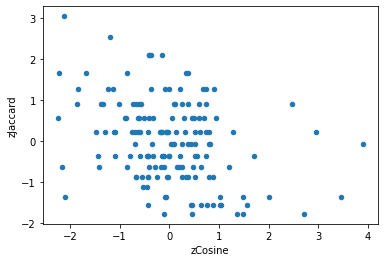

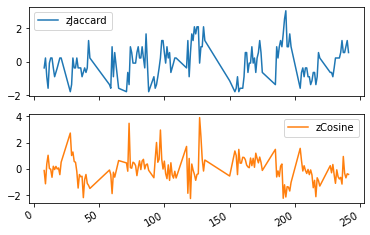

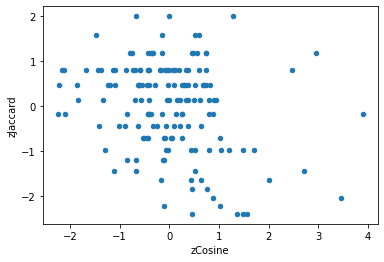

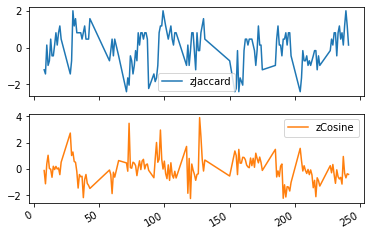

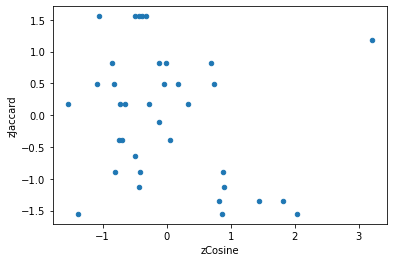

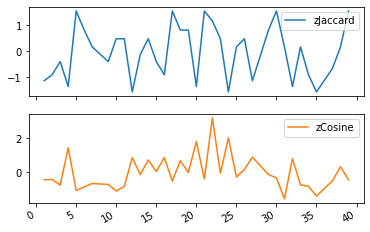

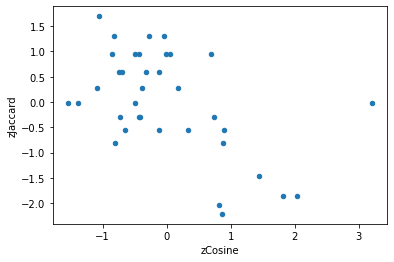

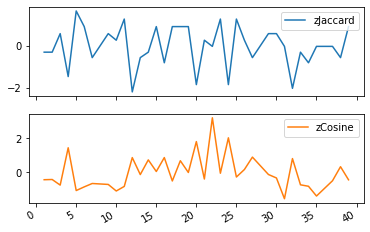

In [21]:
for df, name in zip(score, ["YRL", "YRL100", "TBN", "TBN100"]):
    print(name)
    df.plot.scatter(x='zCosine',y='zJaccard')
    df[["zJaccard", "zCosine"]].plot(subplots = True)